<h1 style="font-size: 42px; margin-bottom: 2px; line-height: 0px;">AirBnB - Data Story</h1>
<h3 style="line-height: 2px; font-style: italic;"> Timothy Baney<h3>

* <a href="#intro" style="text-decoration: none;">Introduction</a>
* <a href="#import" style="text-decoration: none;">Import Libraries</a>
* <a href="#data-structure" style="text-decoration: none;">Data Structure</a>
    * <a href="#observ-variable" style="text-decoration: none;">Observation Variables</a>
    * <a href="#missing-values" style="text-decoration: none;">Missing Values</a>
    * <a href="#cat-values" style="text-decoration: none;">Categorical Values</a>
* <a href="#problem-nature" style="text-decoration: none;">The Nature of the Problem</a>
    * <a href="#time-series" style="text-decoration: none;">Time Series Analysis</a>
    * <a href="#feature-target" style="text-decoration: none;">Feature/Target Analysis</a>
* <a href="#infer-stats" style="text-decoration: none;">Inferential Statistics</a>
* <a href="#final-conc" style="text-decoration: none;">Final Conclusion</a> 

## <p id="intro" style="margin-bottom: 0px; line-height: 1px;">Introduction</p>
<p>This notebook is intended to explore the cleansed AirBnB data that I have wrangled to answer questions related to the structure of the data, about what conclusions can be made from the features of the data related to the target, and to apply some inferential statistics to discover any significance of those findings. Data structure questions include: what features belong to every observation, how many missing values does each feature own, and for any feature that is of type category, how many values does that categorical data have ? When looking at the nature of the problem, and ways to solve it I will analyze any connections that the data features have with the data target, by using several methods including a time series analysis.</p>

## <p id="import">Import Libraries</p>

In [1]:
import datetime
%matplotlib inline

import pylab
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn import datasets, tree
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, RFE
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split

import matplotlib.pylab as pylab

ucb_w_reindex = pd.read_csv('clean_airbnb.csv')
ucb = pd.read_csv('clean_airbnb.csv')

full_country_name = {
    'US': 'United States',
    'FR': 'France',
    'DE': 'Denmark',
    'CA': 'Canada',
    'AU': 'Australia',
    'ES': 'Spain',
    'PT': 'Portugal',
    'IT': 'Italy',
    'GB': 'Great Britian',
    'NL': 'Netherlands'
}

/Users/timothybaney/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/timothybaney/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
ucb.columns

Index(['country_destination', 'gender', 'dest_age_pop', 'age', 'id',
       'date_account_created', 'timestamp_first_active', 'date_first_booking',
       'signup_method', 'signup_flow', 'language', 'affiliate_channel',
       'affiliate_provider', 'first_affiliate_tracked', 'signup_app',
       'first_device_type', 'first_browser', 'lat_destination',
       'lng_destination', 'distance_km', 'destination_km2',
       'destination_language ', 'language_levenshtein_distance',
       'actions_total_count', 'average_action_duration',
       'sessions_total_duration', 'US', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE',
       'NL', 'AU', 'PT'],
      dtype='object')

## <p id="data-structure">Data Structure</p>

### <p id="observ-variable" style="margin-bottom: 0; line-height: 2px;">Observation Variables</p>
We will first explore how many features exist for each observation. We subtract one to be sure not to include the target variable.

In [3]:
len(ucb.columns) - 1

35

The data has 35 different variables

### <p id="missing-values" style="margin-bottom: 0; line-height: 2px;">Missing Values</p>
How many missing values does each feature have ? Missing values can include things like NaN "Not a number", Null, or even 0 for features such as age, where 0 is impossible. We will drop any one hot encoding boolean values (1 or a 0 for if an observation fits a category or not).

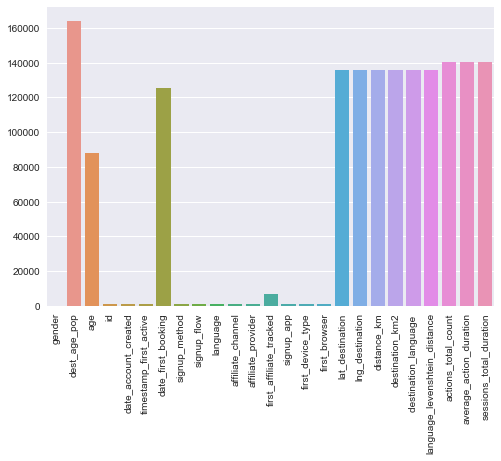

In [4]:
def convertToNull(row):
    if row['age'] == 0:
        return np.nan
    else:
        return row['age']
    
ucb_features = ucb.copy()
ucb_features['age'] = ucb_features.apply(lambda x: convertToNull(x), axis=1)

ucb_features = ucb_features.drop(['country_destination', 'US', 'FR', 'IT', 'GB', 'ES', 'CA', 'DE', 'NL', 'AU', 'PT'], axis=1)

features = ucb_features.columns
feature_nulls = [ucb_features[col].isnull().sum() for col in ucb_features.columns]
fnulls = sns.barplot(features, feature_nulls)
plt.xticks(rotation=90)
plt.show()

There are several missing values for country related features like latitude, longitude, , distance_km2, destination age population, destination_language, and destination_km2. This is because of the target class 'NDF' or 'No Destination found'. This is a user who never booked a trip. This is also a good explanation for why the number of null or missing values for date_first_booking is so high. When merging users and session data, a left join was used in favor of the users dataset which means that any user whose id couldn't be found in a session remained, but received null values for session info. This is why there are so many null values for actions total count, average action durations, and sessions total duration. Unfortunately age, a feature with promising insights has a lot of null values. Any value for age that was zero was considered to be a null value in this case. This simply means that a lot of users don't include their age when signing up.

### <p id="cat-values" style="margin-bottom: 0; line-height: 2px;">Categorical Values</p>
How many unique values does each feature with a type of category have ?

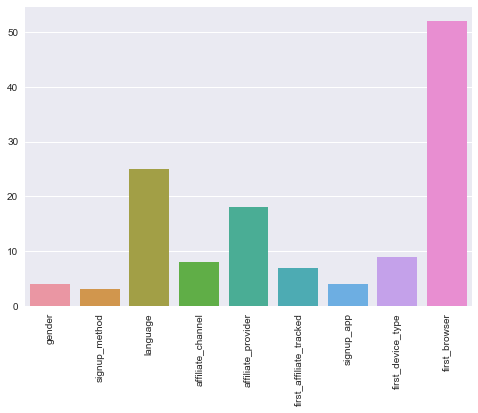

In [5]:
ucb_categories = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', 'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']

feature_values = [ucb[col].value_counts().count() for col in ucb_categories]
feature_values
feature_values
fnulls = sns.barplot(ucb_categories, feature_values)
plt.xticks(rotation=90)
plt.show()

It appears as though most categorical features have less than ten values, the only exceptions being language, affiliate provider, and the first browser used when going to AirBnB.

## <p id="problem-nature">The Nature of the Problem</p>
This project is related to a Kaggle competition for AirBnB. AirBnB hosted the competition because they were looking for an algorithm that would help them improve their destination recommendations to new users. Based on this, the crux of the issue is to find some connection between a users features like age, gender, and browser to what country their first booking was to. If highly accurate predictions can be made based on this information, it will improve the relevance of aformentioned country recommendation. In this section, we will look at feature connections with several differen plot including bar charts, line charts "for time series analysis", and violin plots. ** "A violin plot is a method of plotting numeric data. It is similar to box plots with a rotated kernel density plot on each side. The violin plot is similar to box plots, except that they also show the probability density of the data at different values" - Wikipedia. **

### <p id="time-series" style="margin-bottom: 0; line-height: 2px;">Time Series</p>

In [6]:
ucb_w_reindex['date_account_created'] = pd.to_datetime(ucb['date_account_created'])
ucb_w_reindex = ucb_w_reindex.sort_values('date_account_created', ascending=False)
ucb_w_reindex = ucb_w_reindex.set_index('date_account_created')

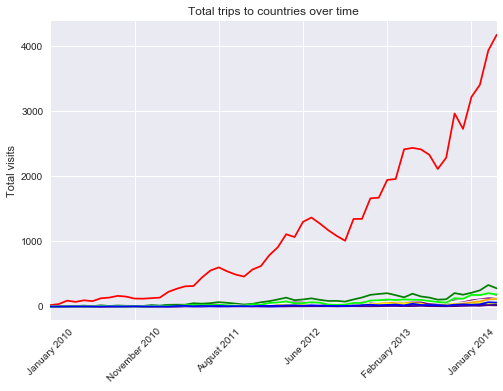

In [7]:
labels = ['January 2010', 'November 2010', 'August 2011', 'June 2012', 'February 2013', 'January 2014']

us_m_ot = ucb_w_reindex.US.resample('M').sum()
fr_m_ot = ucb_w_reindex.FR.resample('M').sum()
au_m_ot = ucb_w_reindex.AU.resample('M').sum()
ca_m_ot = ucb_w_reindex.CA.resample('M').sum()
de_m_ot = ucb_w_reindex.DE.resample('M').sum()
es_m_ot = ucb_w_reindex.ES.resample('M').sum()
pt_m_ot = ucb_w_reindex.PT.resample('M').sum()
gb_m_ot = ucb_w_reindex.GB.resample('M').sum()
it_m_ot = ucb_w_reindex.IT.resample('M').sum()
nl_m_ot = ucb_w_reindex.NL.resample('M').sum()

ax = sns.tsplot(data=us_m_ot, color='red')
sns.tsplot(data=fr_m_ot, color='green')
sns.tsplot(data=au_m_ot, color='blue')
sns.tsplot(data=ca_m_ot, color='orange')
sns.tsplot(data=de_m_ot, color='yellow')
sns.tsplot(data=es_m_ot, color='purple')
sns.tsplot(data=pt_m_ot, color='indigo')
sns.tsplot(data=gb_m_ot, color='white')
sns.tsplot(data=it_m_ot, color='lime')
sns.tsplot(data=nl_m_ot, color='blue')
ax.set_xticklabels(labels)
plt.title('Total trips to countries over time')
plt.xticks(rotation=45)
plt.ylabel('Total visits')
plt.show()

Bookings to the United States over time are clearly getting more prevalant

/Users/timothybaney/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: FutureWarning: 
.resample() is now a deferred operation
You called rolling(...) on this deferred object which materialized it into a series
by implicitly taking the mean.  Use .resample(...).mean() instead


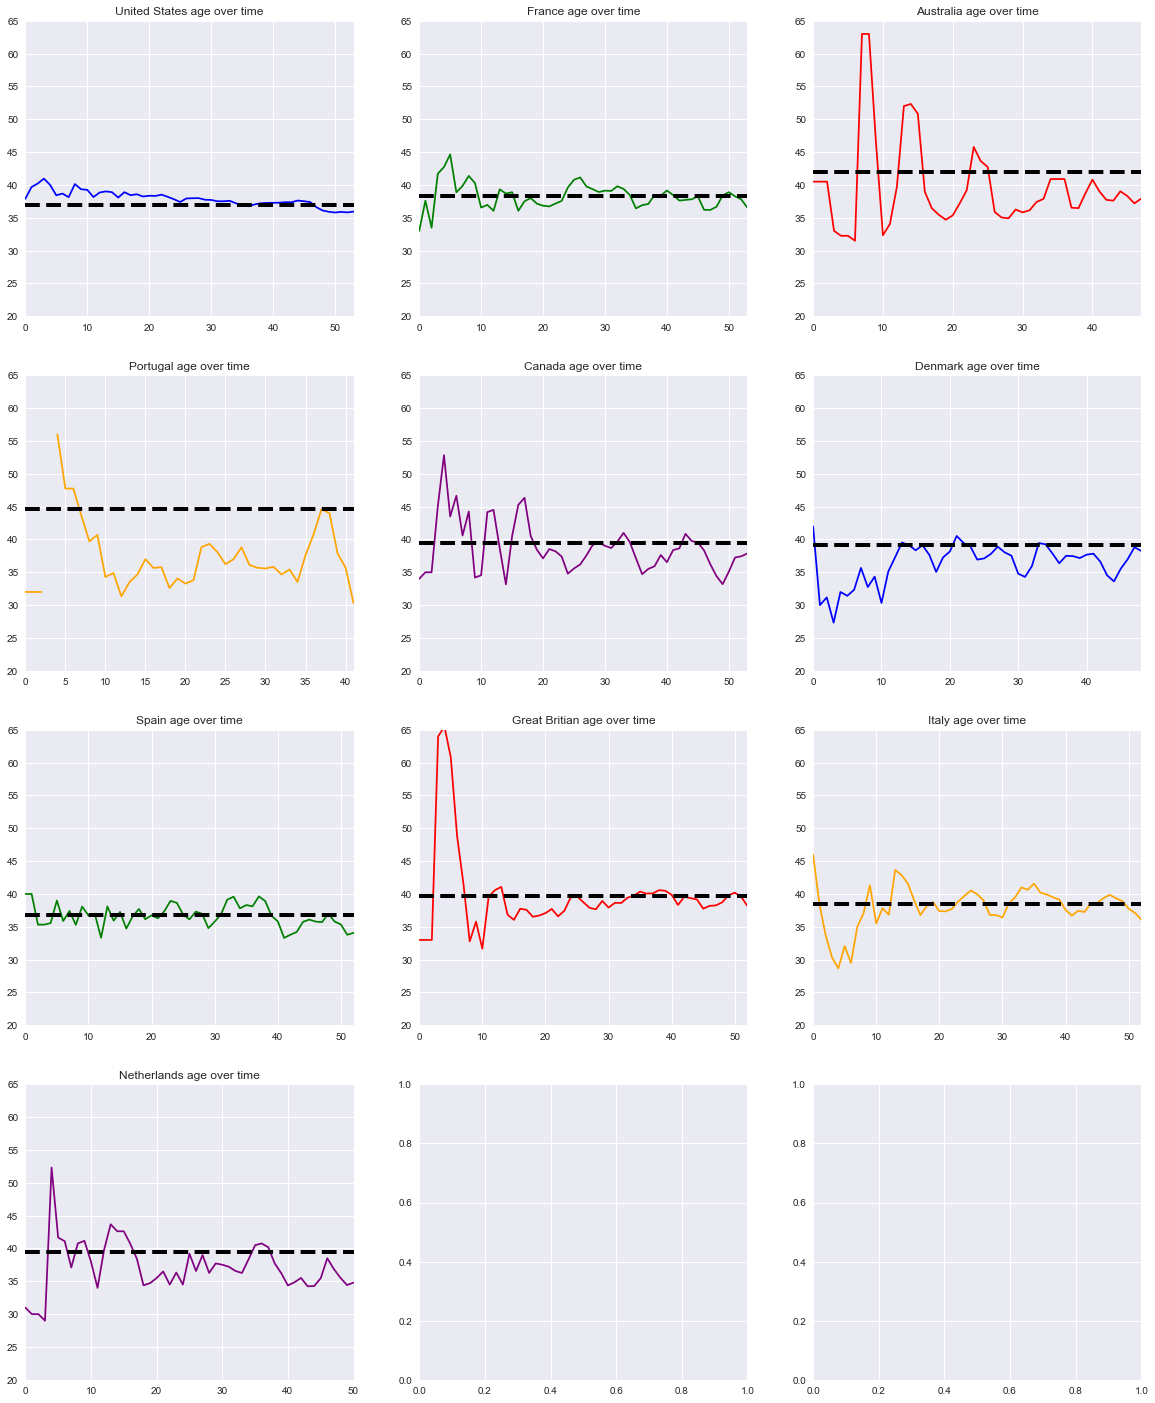

In [8]:
ucb_w_reindex_age = ucb_w_reindex[np.isfinite(ucb_w_reindex['age'])]
ucb_w_reindex_age = ucb_w_reindex_age.loc[ucb_w_reindex_age['age'] < 120]


def ageSeries(country):
    return ucb_w_reindex_age.loc[ucb_w_reindex_age['country_destination'] == country].age.fillna(value=30).resample('m').rolling(window=3, min_periods=1).mean()

def avgAge(country):
    return ucb_w_reindex_age.loc[ucb_w_reindex_age['country_destination'] == country].age.mean()

num_plots = 10
fig, axes = plt.subplots(4,3,figsize=(20,25))

list_of_dfs = [{'country': item, 'age': ageSeries(item), 'avgAge': avgAge(item)} for item in ['US', 'FR', 'AU', 'PT', 'CA', 'DE', 'ES', 'GB', 'IT', 'NL']]

colors = ['blue', 'green', 'red', 'orange', 'purple', 'blue', 'green', 'red', 'orange', 'purple']
col, row, loop = (0, 0, 0)
for obj in list_of_dfs:
    row = math.floor(loop/3)
    
    sns.tsplot(data=obj['age'], color=colors[loop], ax=axes[row, col])
    axes[row, col].set_title('{} age over time'.format(full_country_name[obj['country']]))
    axes[row, col].axhline(obj['avgAge'], color='black', linestyle='dashed', linewidth=4)
    axes[row, col].set(ylim=(20, 65))
        
    col += 1
    loop += 1
    
    if col == 3:
        col = 0
        
plt.show()

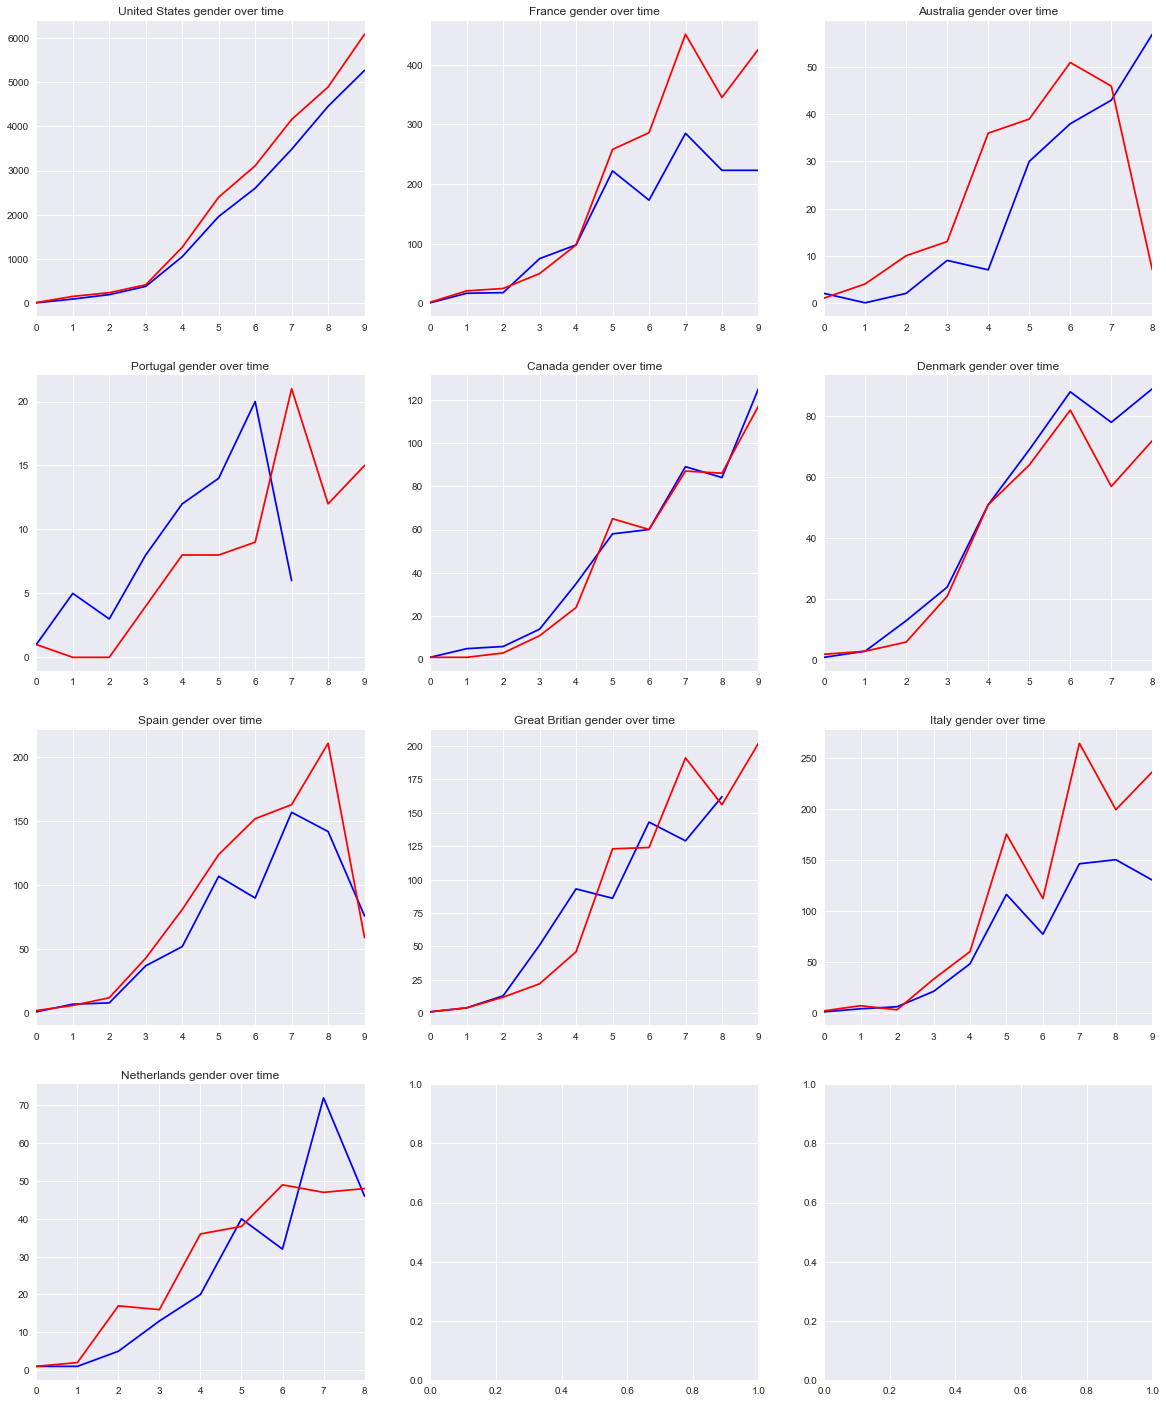

In [9]:
ucb_w_reindex_gender = ucb_w_reindex.copy()

def genderSeries(country, gender):
    return ucb_w_reindex_gender.loc[(ucb_w_reindex_gender['country_destination'] == country) & (ucb_w_reindex_gender['gender'] == gender)]['gender'].fillna(method='ffill').resample('6M').count()

list_of_dfs = [{'country': item, 'dmale': genderSeries(item, 'male'), 'dfem': genderSeries(item, 'female')} for item in ['US', 'FR', 'AU', 'PT', 'CA', 'DE', 'ES', 'GB', 'IT', 'NL']]

num_plots = 10
fig, axes = plt.subplots(4,3,figsize=(20,25))

col, row, loop = (0, 0, 0)
for obj in list_of_dfs:
    row = math.floor(loop/3)
    
    sns.tsplot(data=obj['dmale'], color='blue', ax=axes[row, col])
    sns.tsplot(data=obj['dfem'], color='red', ax=axes[row, col])
    axes[row, col].set_title('{} gender over time'.format(full_country_name[obj['country']]))
        
    col += 1
    loop += 1
    
    if col == 3:
        col = 0

plt.show()

From the time series above, we can make a few conclusions. One thing that definitely stands out from the total number of trips booked for each country over time is that the total number of trips to the United States is skyrocketing while other European countries are seeing a modest rise at best. By looking at the average age per user for each country, we can see that for the United States, and the Netherlands, they are starting to attract younger users, and that the average age in general for visitors to Australia is noteably higher than other countries. In regards to the total number of men vs women booking trips over time for each country, they grow or fall about equally with each other except for Italy, and France, where the the number of males is leveling off, but female visitors continue to grow. In Australia however, it is the opposite, and to an even more extreme extent. More males are going, but the number of females booking trips there is sharply dropping.

### <p id="feature-target" style="margin-bottom: 0; line-height: 2px;">Feature/Target Analysis</p>

In [63]:
ucb = pd.read_csv('clean_airbnb.csv')

ucb = ucb.dropna(subset=['date_account_created'])

/Users/timothybaney/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
def getMonth(row):
    months = {
        '01': 'January',
        '02': 'February',
        '03': 'March',
        '04': 'April',
        '05': 'May',
        '06': 'June',
        '07': 'July',
        '08': 'August',
        '09': 'September',
        '10': 'October',
        '11': 'November',
        '12': 'December'
    }
    
    if row['date_account_created'] != 'nan':
        month = int(str(row['date_account_created']).split('-')[1])
    else:
        month = np.nan
        
    return month
    
ucb['month'] = ucb.apply(lambda x: getMonth(x), axis=1)

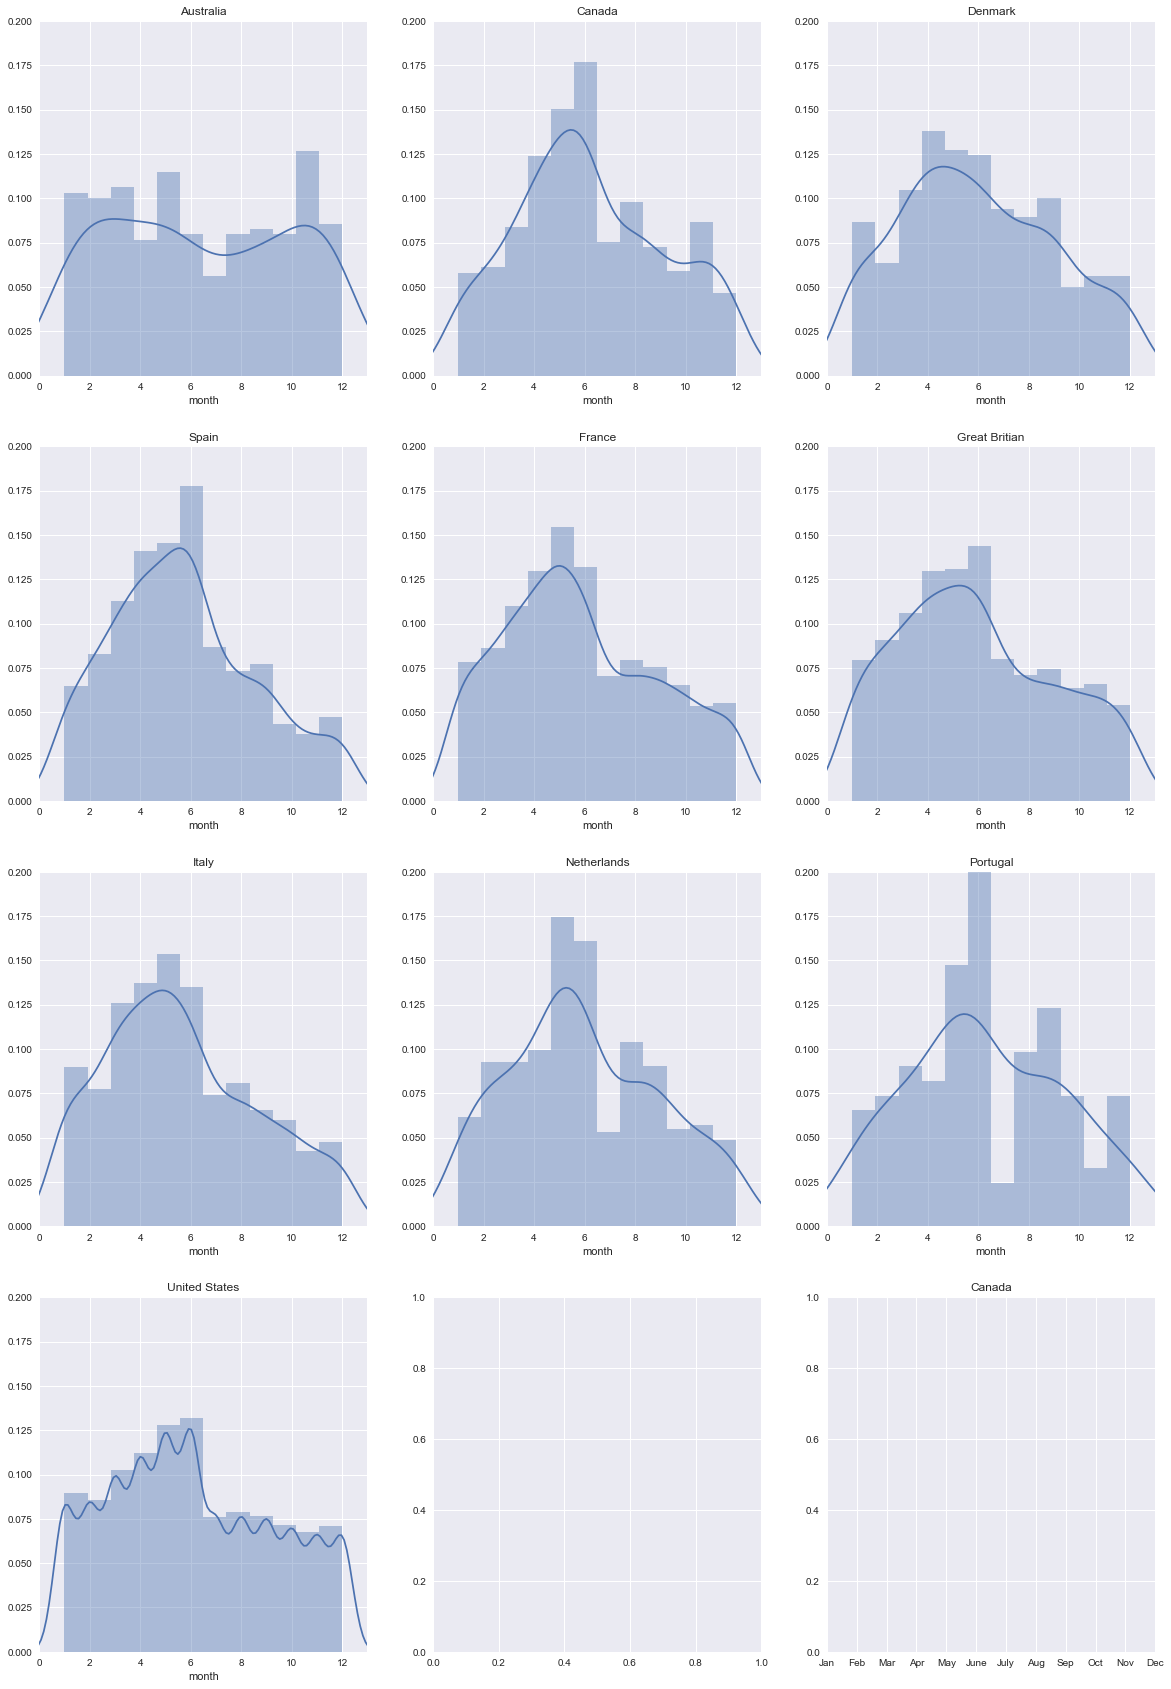

In [79]:
num_plots = 10
fig, axes = plt.subplots(4,3, figsize=(20,30))

def buckets(i):
    return [ucb.country_destination.unique()[i]]

col, row, loop = (0, 0, 0)
# iterate through all axes and create a violin plot
for i in range(num_plots):
    row = math.floor(loop/3)

    data = ucb[ucb.country_destination.isin(buckets(i))]
    x = data['month']
    
    objects = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec')
    y_pos = np.arange(len(objects))
    
    ax_curr = axes[row, col]
    
    title = full_country_name[buckets(i)[0]]
    
    sns.distplot(x, bins=12, ax=ax_curr)
    plt.title('Canada')
    ax_curr.set_title(title)
    ax_curr.set_ylim([0, .2])
    ax_curr.set_xlim([0, 13])

    plt.xticks(y_pos, objects)
    
    col += 1
    loop += 1
    
    if col == 3:
        col = 0

plt.show()

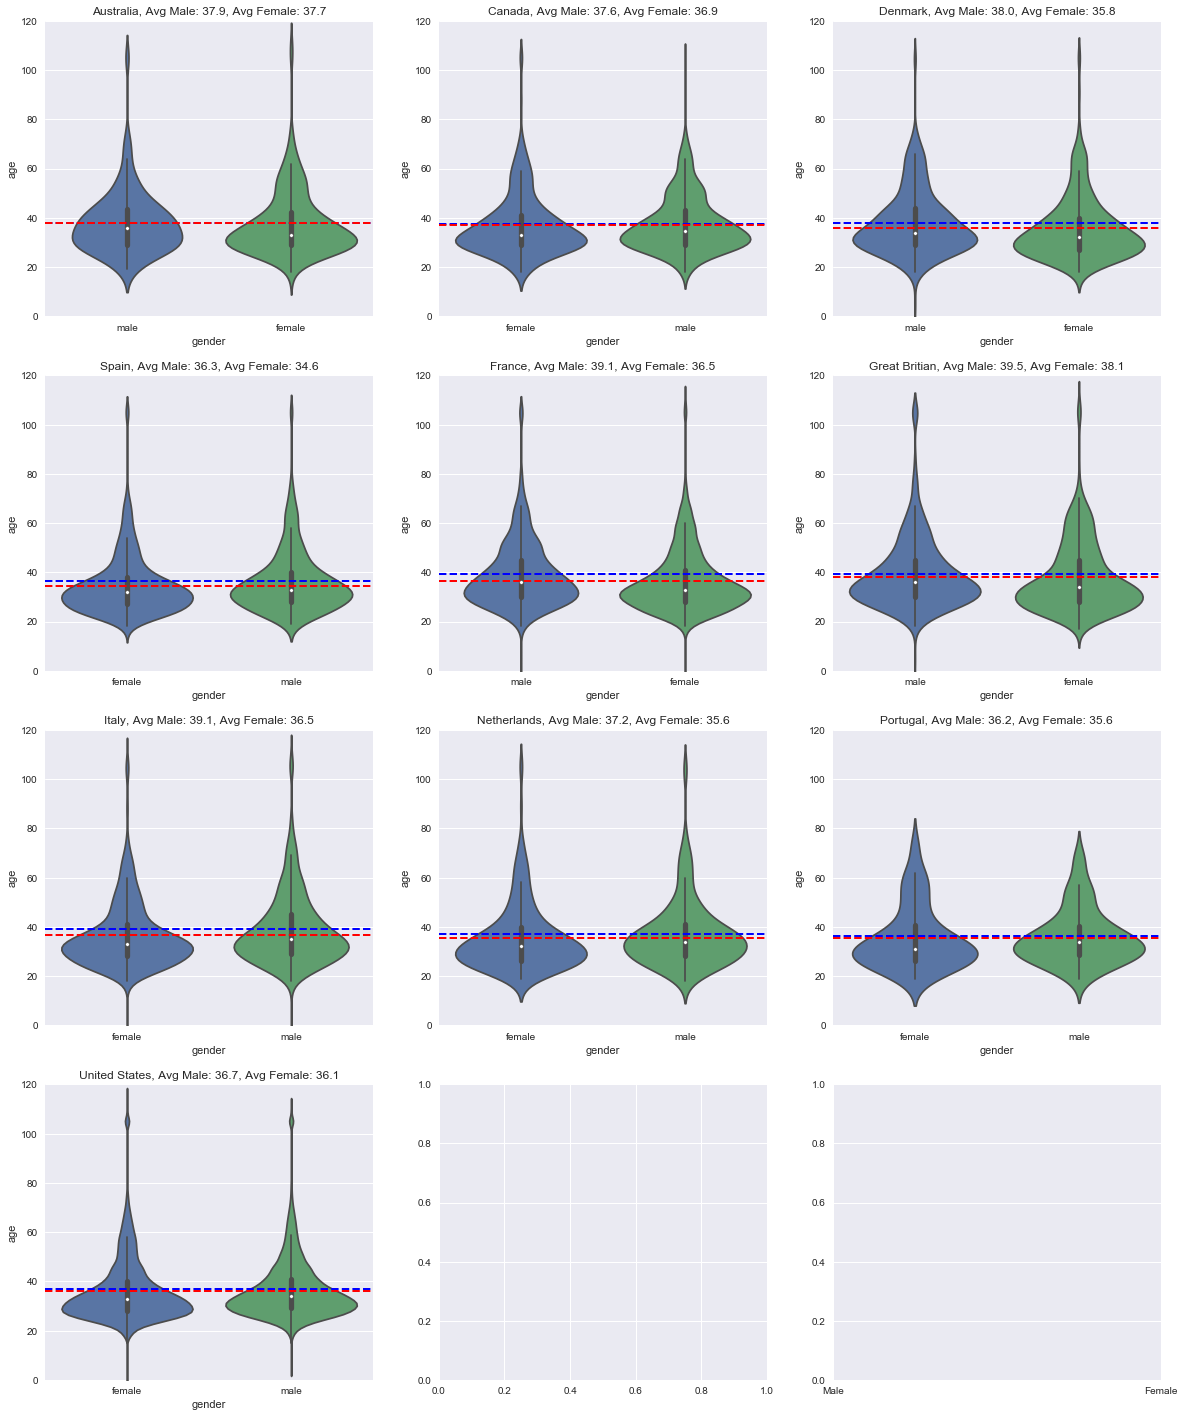

In [83]:
ucb = ucb[np.isfinite(ucb['age'])]
ucb = ucb.loc[(ucb['age'] < 120) & (ucb['age'] > 0)]
ucb = ucb.loc[(ucb['gender'] == 'male') | (ucb['gender'] == 'female')]

num_plots = 10
fig, axes = plt.subplots(4,3,figsize=(20, 25))

def buckets(i):
    return [ucb.country_destination.unique()[i]]

col, row, loop = (0, 0, 0)
# iterate through all axes and create a violin plot
for i in range(num_plots):
    row = math.floor(loop/3)
    
    data = ucb[ucb.country_destination.isin(buckets(i))]


    
    male_mean = round(data.loc[data['gender'] == 'male'].age.mean(), 1)
    female_mean = round(data.loc[data['gender'] == 'female'].age.mean(), 1)
    
    objects = ('Male', 'Female')
    y_pos = np.arange(len(objects))
    
    ax_curr = axes[row, col]
    
    title = full_country_name[buckets(i)[0]]
        
    sns.violinplot(x="gender", y="age", data=data, ax=ax_curr)
    ax_curr.set_title('{}, Avg Male: {}, Avg Female: {}'.format(title, male_mean, female_mean))
    ax_curr.set_ylim([0, 120])
    ax_curr.axhline(male_mean, color='b', linestyle='dashed', linewidth=2)
    ax_curr.axhline(female_mean, color='r', linestyle='dashed', linewidth=2)

    plt.xticks(y_pos, objects)
    
    col += 1
    loop += 1
    
    if col == 3:
        col = 0

plt.show()

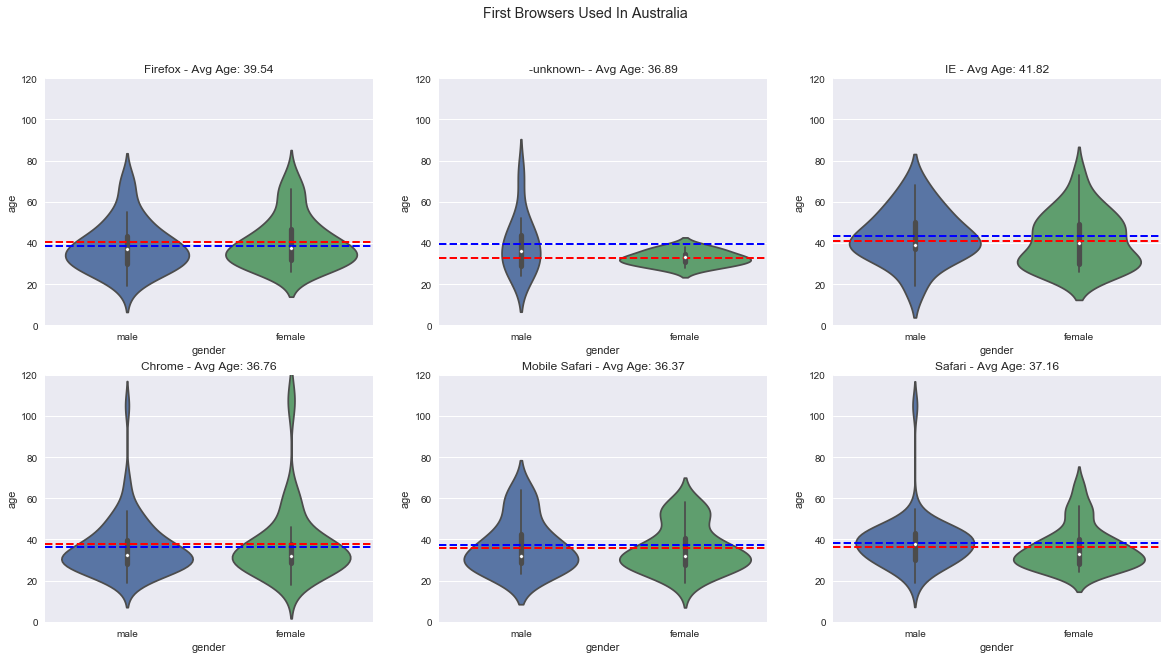

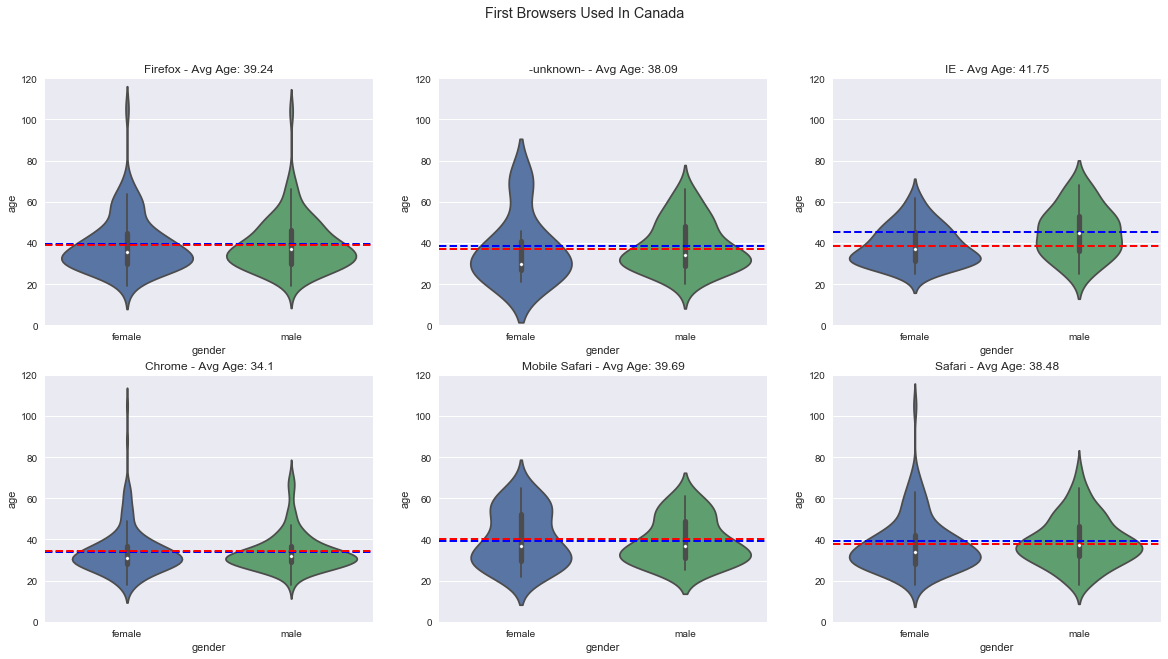

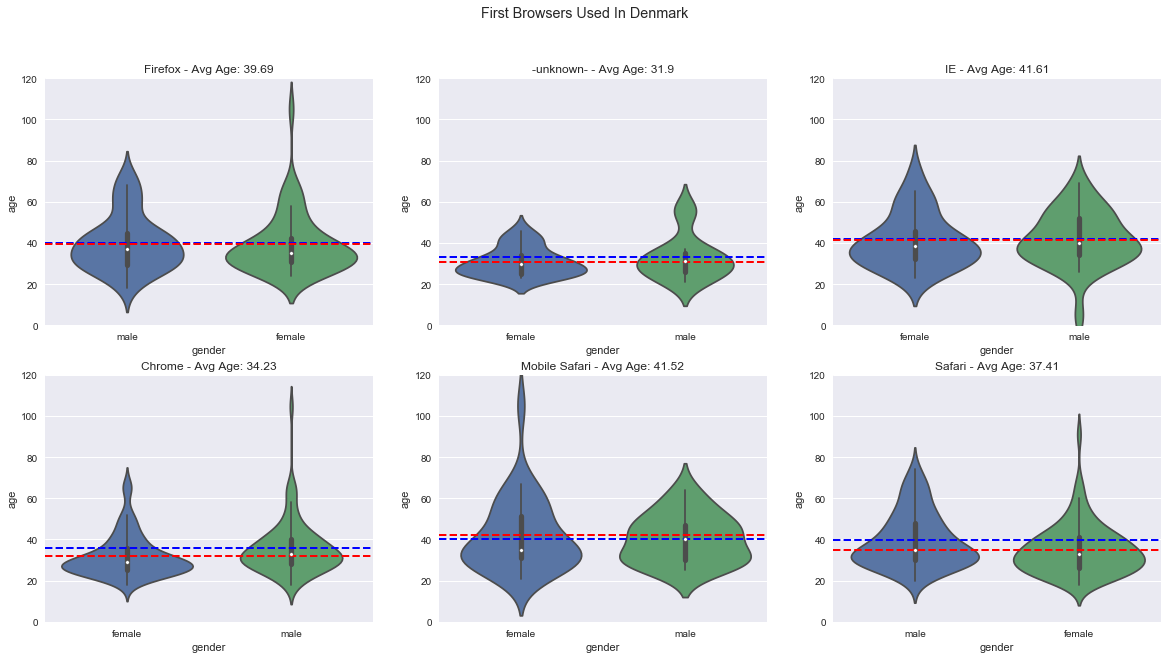

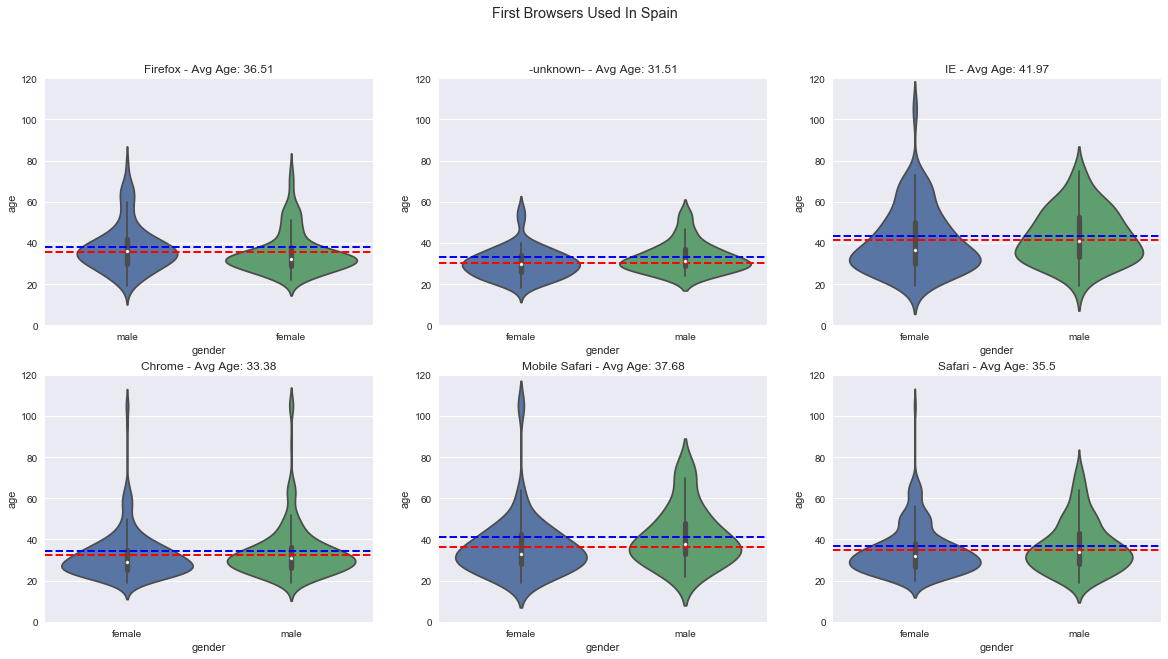

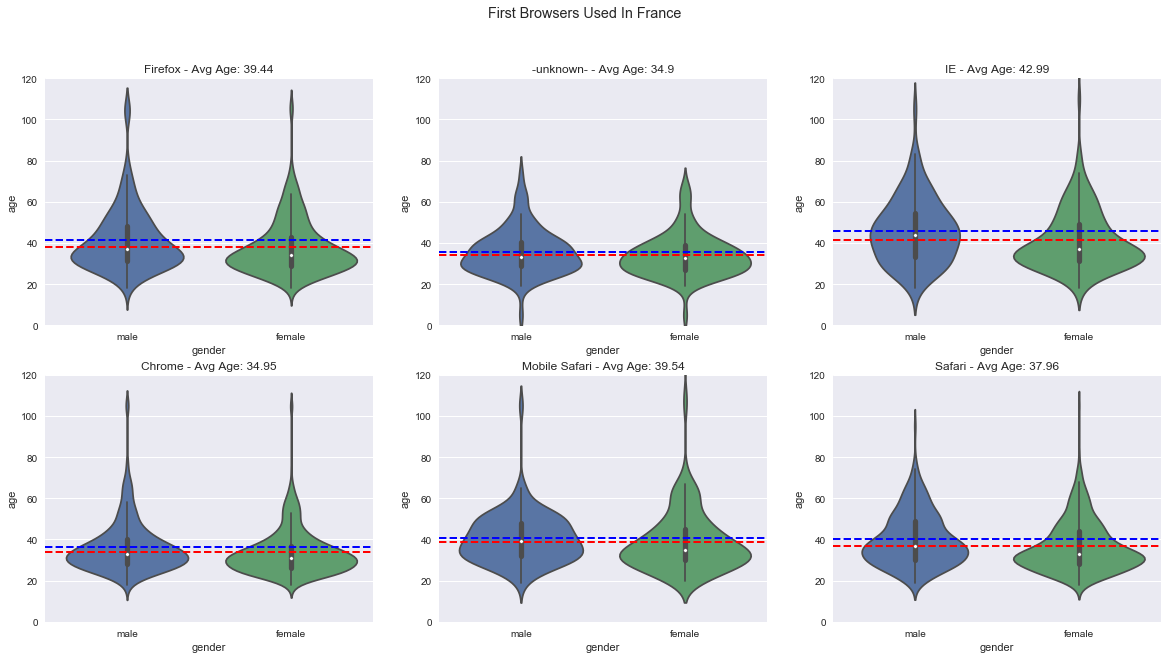

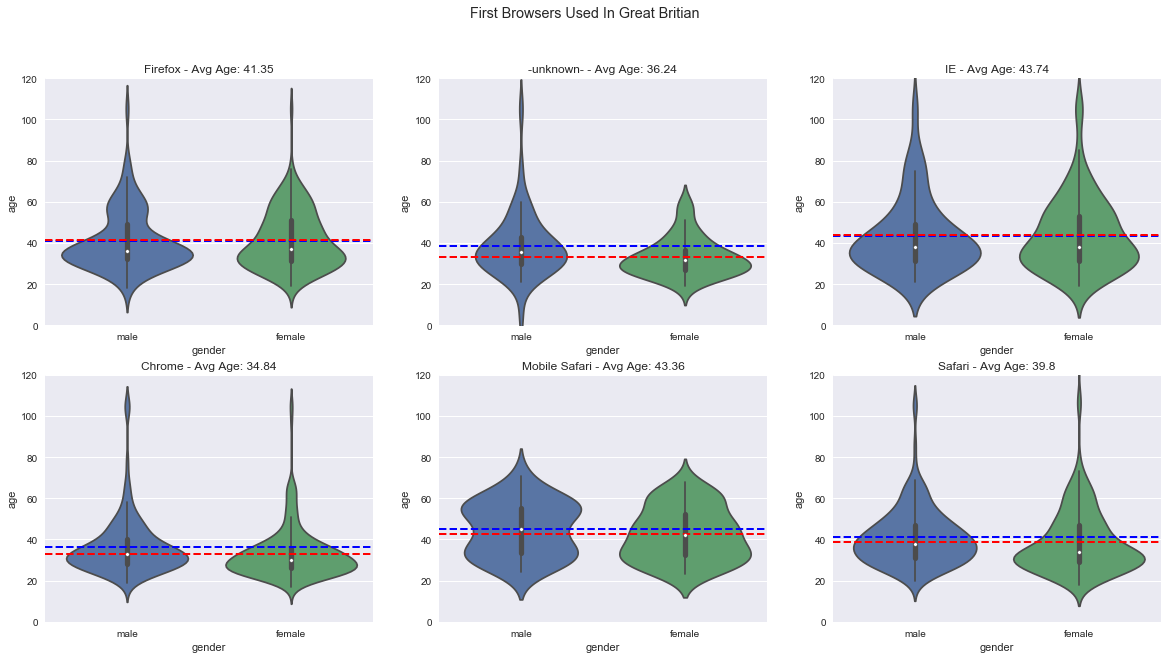

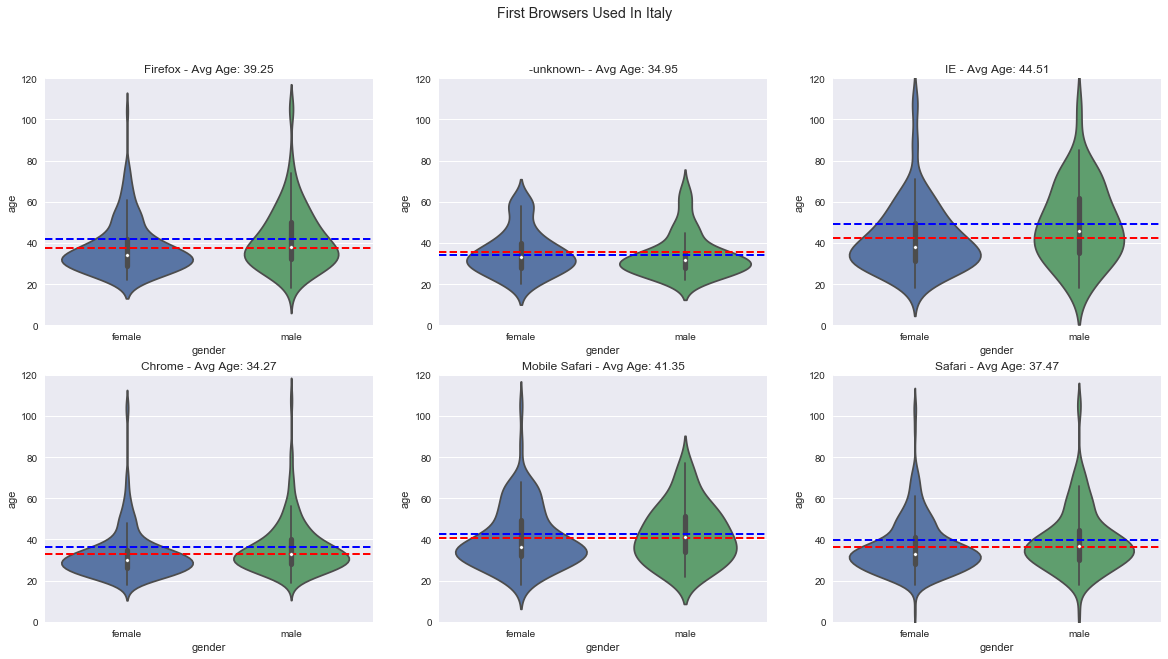

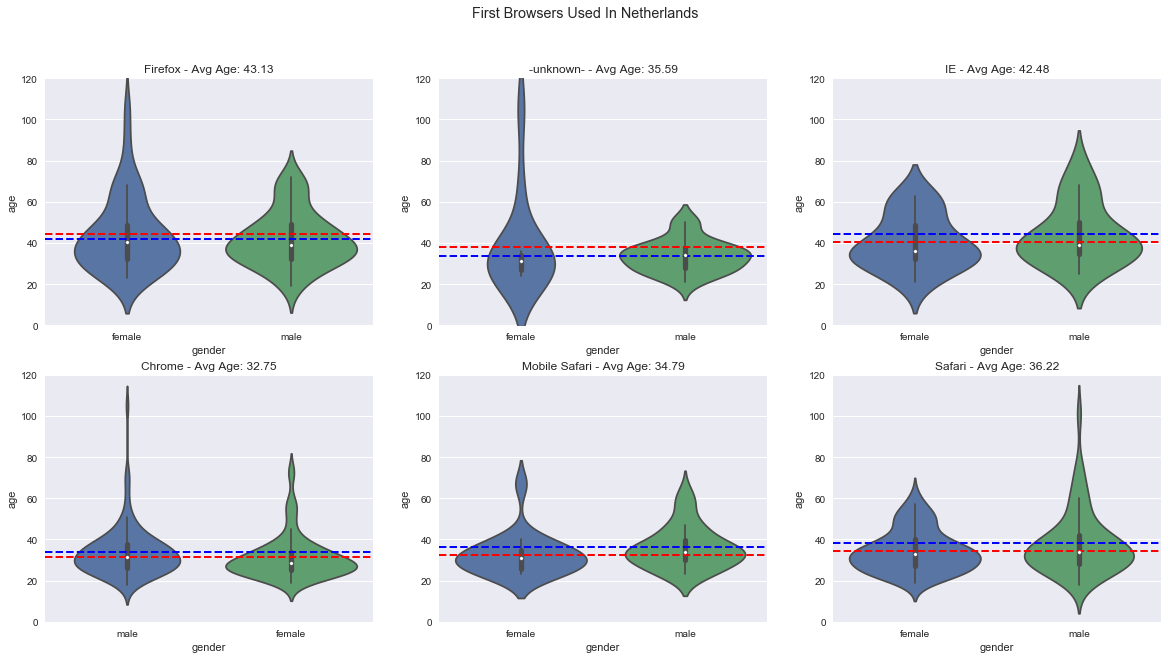

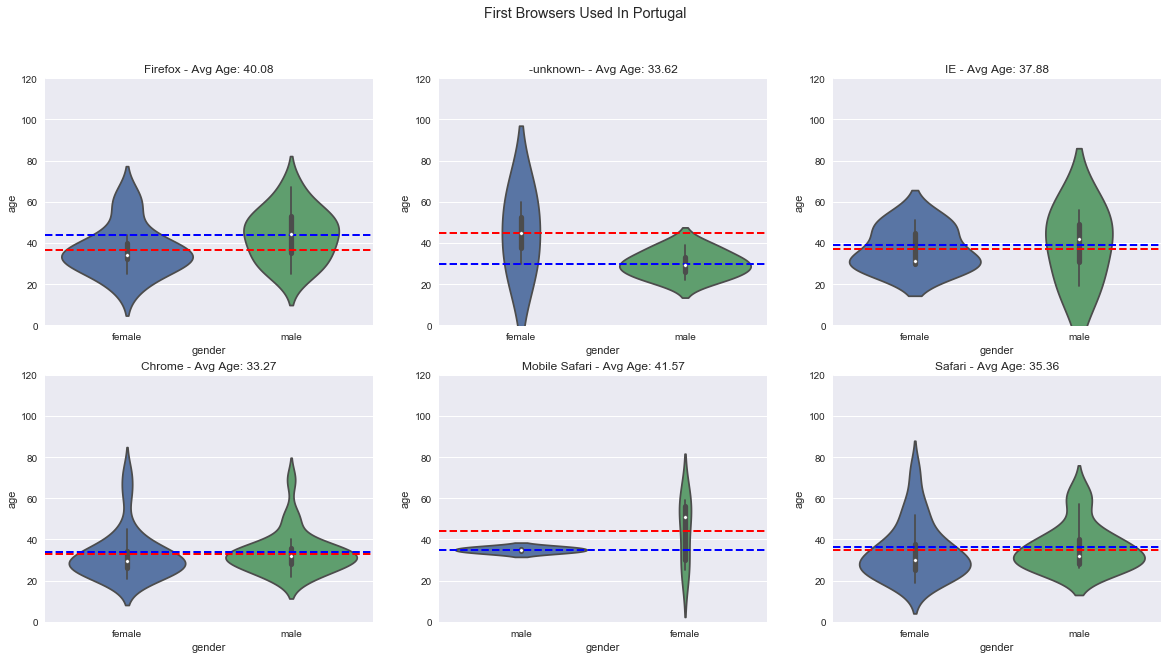

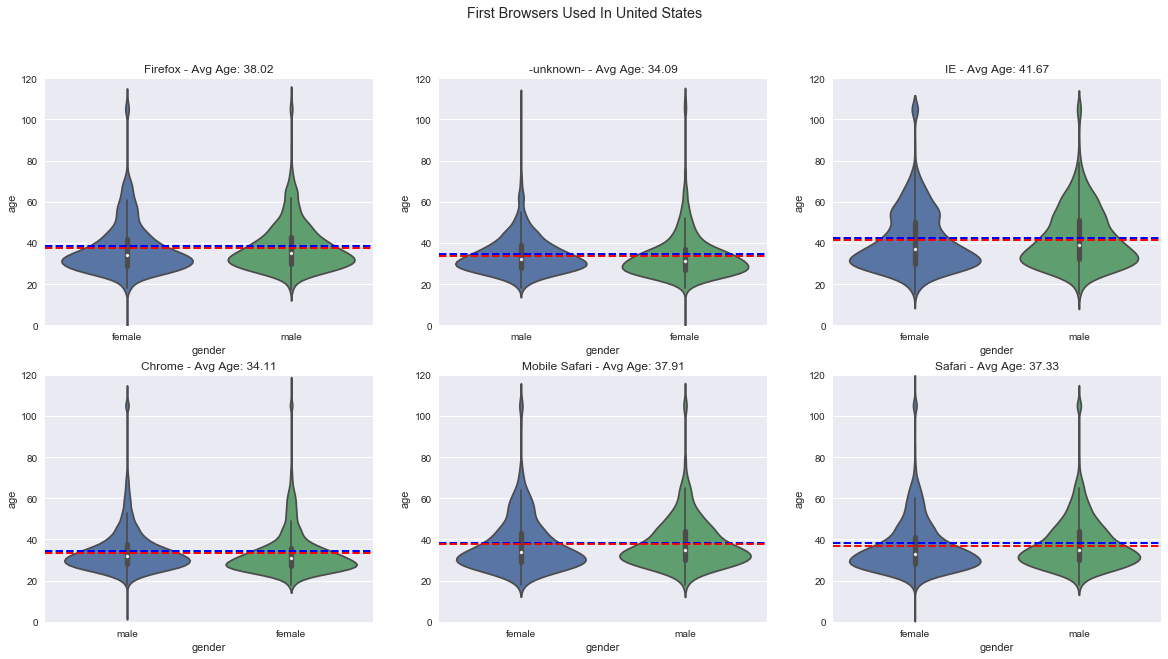

In [94]:
country_plots = 10
def country_buckets(i):
    return [ucb.country_destination.unique()[i]]

num_plots = 6
def buckets(i):
    return [ucb.first_browser.unique()[i]]

for x in range(country_plots):
    col, row, loop = (0, 0, 0)
    
    fig, axes = plt.subplots(2,3,figsize=(20,10))
    for i in range(num_plots):
        row = math.floor(loop/3)
        # Get all data for this browser, Google, and than filter it down by country
        data = ucb[ucb.first_browser.isin(buckets(i)) & ucb.country_destination.isin(country_buckets(x))]

        male_mean = data.loc[data['gender'] == 'male'].age.mean()
        female_mean = data.loc[data['gender'] == 'female'].age.mean()

        ax_curr = axes[row, col]

        title = buckets(i)[0]
        avg_age = round(data.age.mean(), 2)
        country_title = full_country_name[country_buckets(x)[0]]

        sns.violinplot(x="gender", y="age", data=data, ax=ax_curr) 
        ax_curr.set(ylim=(0, 120))
        ax_curr.set_title('{} - Avg Age: {}'.format(title, avg_age))
        ax_curr.axhline(male_mean, color='b', linestyle='dashed', linewidth=2)
        ax_curr.axhline(female_mean, color='r', linestyle='dashed', linewidth=2)
        
        col += 1
        loop += 1

        if col == 3:
            col = 0

    fig.suptitle('First Browsers Used In {}'.format(country_title))
plt.show()

In [106]:
dest_size_fem = ucb.loc[ucb['gender'] == 'female']['destination_km2'].mean()
dest_size_male = ucb.loc[ucb['gender'] == 'male']['destination_km2'].mean()
'{} {}'.format(dest_size_male, dest_size_fem)
x = ['country size by male', 'country size by female']
y = [dest_size_male, dest_size_fem]

dist_under_18 = ucb.loc[ucb['age'] <= 18]['distance_km'].mean()
dist_19_25 = ucb.loc[ucb['age'] >= 19].loc[ucb['age'] < 26]['destination_km2'].mean()
dist_26_31 = ucb.loc[ucb['age'] >= 26].loc[ucb['age'] < 32]['destination_km2'].mean()
dist_32_40 = ucb.loc[ucb['age'] >= 32].loc[ucb['age'] < 41]['destination_km2'].mean()
dist_41_50 = ucb.loc[ucb['age'] >= 41].loc[ucb['age'] < 51]['destination_km2'].mean()
dist_51_60 = ucb.loc[ucb['age'] >= 51].loc[ucb['age'] < 61]['destination_km2'].mean()

dist_61_up = ucb.loc[ucb['age'] >= 61]['destination_km2'].mean()
x_age = ['>19', '19-25', '26-31', '32-40', '41-50', '51-60', '60+']
y_age = [dist_under_18, dist_19_25, dist_26_31, dist_32_40, dist_41_50, dist_51_60, dist_61_up]

su_facebook = ucb.loc[ucb['signup_method'] == 'facebook']['destination_km2'].mean()
su_google = ucb.loc[ucb['signup_method'] == 'google']['destination_km2'].mean()
su_basic = ucb.loc[ucb['signup_method'] == 'basic']['destination_km2'].mean()
x_sup = ['Facebook', 'Google', 'Basic']
y_sup = [su_facebook, su_google, su_basic]

suapp_web = ucb.loc[ucb['signup_app'] == 'Web']['destination_km2'].mean()
suapp_ios = ucb.loc[ucb['signup_app'] == 'iOS']['destination_km2'].mean()
suapp_android = ucb.loc[ucb['signup_app'] == 'Moweb']['destination_km2'].mean()
suapp_moweb = ucb.loc[ucb['signup_app'] == 'Android']['destination_km2'].mean()
x_suapp = ['Web', 'iOS', 'Android', 'Moweb']
y_suapp = [suapp_web, suapp_ios, suapp_android, suapp_moweb]

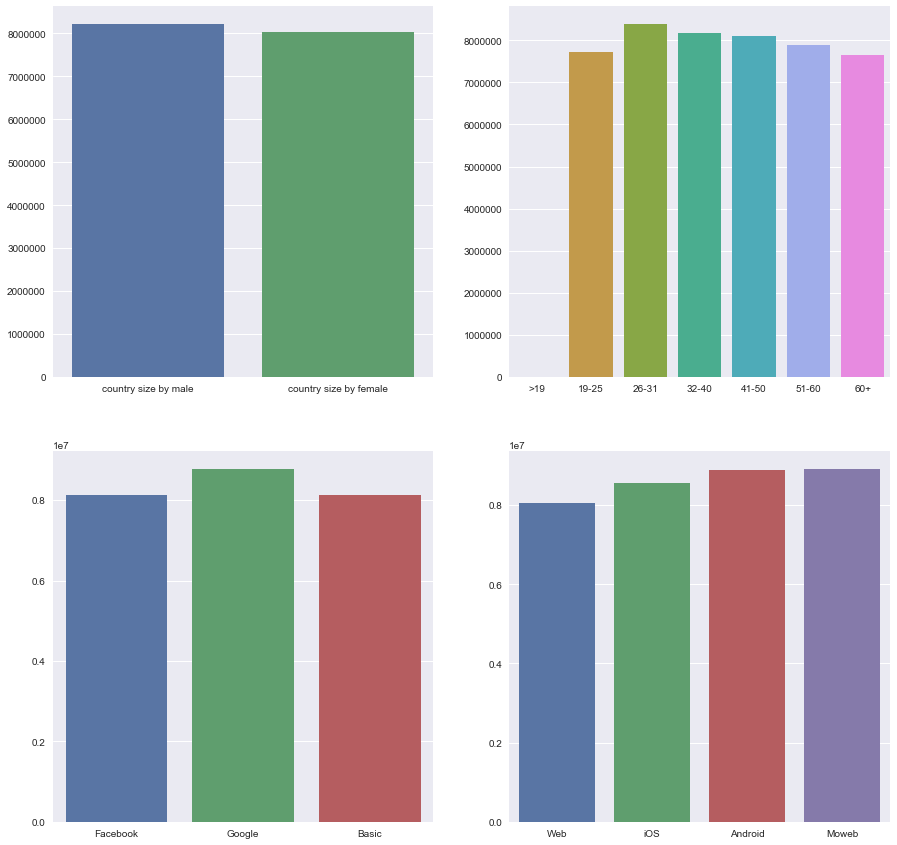

In [107]:
num_plots = 4
fig, axes = plt.subplots(2,2,figsize=(15,15))

sns.barplot(x, y, ax=axes[0, 0])
sns.barplot(x_age, y_age, ax=axes[0, 1])
sns.barplot(x_sup, y_sup, ax=axes[1, 0])
sns.barplot(x_suapp, y_suapp, ax=axes[1, 1])
plt.show()

In [97]:
ucb = ucb.sort_values('destination_km2', ascending=False)
fifths = ucb.iloc[0:1]['destination_km2'] / 5
fifths

1248    1996934.0
Name: destination_km2, dtype: float64

In [100]:
x_small = ucb.loc[ucb['destination_km2'] < 2000000].age.mean()
small = ucb.loc[ucb['destination_km2'] >= 2000000].loc[ucb['destination_km2'] < 4000000]
medium = ucb.loc[ucb['destination_km2'] >= 4000000].loc[ucb['destination_km2'] < 6000000]
large = ucb.loc[ucb['destination_km2'] >= 6000000].age.mean()

def getCountrySize(row):
    if row['destination_km2'] < 5000000:
        return 'small'
    else:
        return 'large'

ucb['size_dest'] = ucb.apply(lambda x: getCountrySize(x), axis=1)

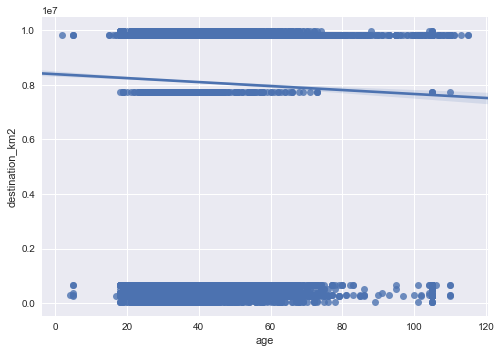

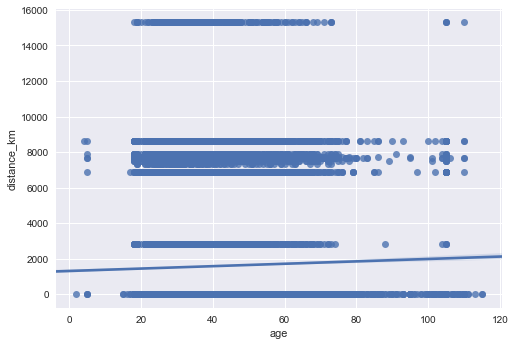

In [101]:
des = sns.regplot('age', 'destination_km2', data=ucb)
plt.show()

dis = sns.regplot('age', 'distance_km', data=ucb)
plt.show()

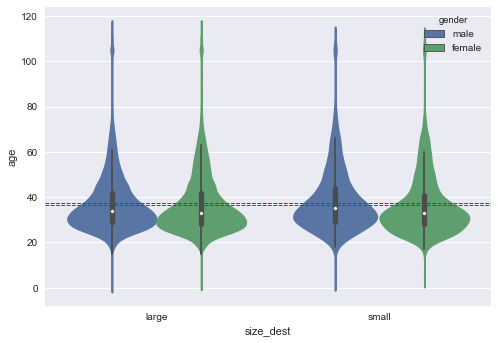

In [103]:
dest = sns.violinplot('size_dest', 'age', data=ucb, hue='gender')
dest.axhline(x_small, color='r', linestyle='dashed', linewidth=1)
dest.axhline(large, color='g', linestyle='dashed', linewidth=1)
plt.show()

## <p id="infer-stats">Inferential Statistics</p>

### Was there any big differences between 1 country and another ? like age, or the number of one gender vs. the other. What was the likelihood that it was simply due to chance ?